<h1> Part 3: Introduction </h1>

<div> The goal of this lab is threefold:
    <ul>
        <li> To make minimal amount of changes to our existing code to implement multi GPU implementation.</li>
        <li> Reiterate the basic principles involved in training of a neural network this time applied to a multi GPU example. </li>
        <li> Illustrate how increasing the number of GPUs affects the batch size and the training process behavior</li>
    </ul>
</div>
<br/>
<div>As discussed in the lecture we will modify our neural network implementation by:
<ul>
<li>Making a copy of our model and pinning each to a different GPU</li>
<li>Implementing a mechanism through which gradients computed by each of the copies can be averaged (which is the essence of the Data Parallel implementation of Stochastic Gradient Descent).</li>
</ul>

    
<br/> This code example implements an approach referred to as in-graph replication. This means that we have just a single process and a single execution graph.  Parts of this execution graph (the same copies of the model) are distributed across multiple GPUs. In our case we have made further simplifications by forcing model parameters (so W and B) to be not only shared between the model copies but also hosted in the computer memory. In this case the host memory becomes our “Parameter Server”. This approach is the simplest implementation of the Model Parallelism possible in TensorFlow. In practice it is rarely used as it introduces significant load on both the PCIe bus as well as the rest of the host system. 
<br/><br/>
<h3> A side note</h3>
A much more common (and substantially more efficient approach) is referred to as between-graph replication. In this approach every copy of the graph is managed by a separate process and each of the processes will have its own TensorFlow session and full copy of both the graph and model parameters. The communication between GPUs can be handled in a unique way, either through the TensorFlow communication mechanism or preferably using the NVIDIA Collective Communication Library (NCCL). NCCL is a very efficient library that allows multiple GPU, within the same system (using NVLINK) or within the same network to exchange the content of their memory directly without engaging the CPU or other computer resources. We will discuss the challenges involved in exchanging parameters as well as a substantially more efficient approach in more detail in Lecture and Lab 2 which discusses engineering challenges of scale.
</div>

<h1> Code review </h1>
<div> Lets step through the code together and discuss changes we have made to the neural network implemented in the previous lab.   </div>


In [1]:
import logging
# Suppress any unnecessary messages to make the output cleaner
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


<div>We will use this variable to decide how many GPUs we want to assign to this process. Bear in mind that this virtual machine has finite amount of resources.</div>

In [2]:
# We define how many GPUs we want to use
num_gpus = 4

<div>Once again we define the hyperparameters of our model and the learning process</div>

In [3]:
# Parameters
learning_rate = 0.1
num_steps = 5000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

<div>Since we will have more than one device working on our problem we need to implement a mechanism to keep track of the progress</div>

In [4]:
# Create a variable to count the number of train() calls. This equals the
# number of batches processed * FLAGS.num_gpus.
global_step = tf.get_variable(
    'global_step', [],
    initializer=tf.constant_initializer(0), trainable=False)

<div>Since we will be creating multiple copies of the model it makes sense to define our model in a function that can be called multiple times (once per GPU). Since we will be sharing model parameters between the copies of the model we do not define W and B here but we pass them as the parameters of our function. By convention a copy of a model deployed on a GPU is referred to as Tower (because our models are very deep/tall and the resulting graph resembles multiple towers).</div>

In [5]:
# Since every GPU will receive a copy of the same model (tower) we will define a function for model creation
# which will help us deploy it across the devices
def tower(W,B):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder("float", [None, num_input], name="X")
    Y = tf.placeholder("float", [None, num_classes], name="Y")
    
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(X, W['h1']), B['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, W['h2']), B['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, W['out']) + B['out']

    # And a softmax to give us the actual prediction
    prediction = tf.nn.softmax(out_layer)
    
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name = 'accuracy')

    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=out_layer, labels=Y), name = 'loss')
    
    return loss, accuracy

In [6]:
# Once again we use the Adam optimiser
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

<div>In this section we define shared model parameters. We then iterate over our GPUs and create a copy of our model on every device.</div>

In [7]:
tower_grads = []
loss_arr = []
acc_arr = []

# We create a shared copy of the model parameters in the host memory (we are not enforcing GPU placement)
with tf.variable_scope("sharedParameters",reuse=True) as scope:
    W = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
    }
    B = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }
    
for i in range(num_gpus):
    with tf.device('/device:GPU:%d' % i):
        scopeName = '%s_%d' % ("tower", i)
        with tf.variable_scope(scopeName,reuse=True) as scope:
            # We create a copy of our model for every GPU and prefix all of the parameters
            # with a scope indicating GPU placement (tower_0, tower_1, etc.).
            loss, accuracy = tower(W,B)
            loss_arr.append(loss)
            acc_arr.append(accuracy)
            # We want to calculate the gradient of the loss with respect to all variables
            # but only the variables in this scope (so in this tower)
            grads = optimizer.compute_gradients(loss)#,
                                                #var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scopeName))
            
            # We store all of the calculated gradients for all towers in an array so they can be aggregated
            tower_grads.append(grads)

In [8]:
# Once again we define variables that will allow us to monitor our training process.
total_loss = tf.reduce_mean(loss_arr)
total_acc = tf.reduce_mean(accuracy)

<div>Since now we have multiple copies of the model and every copy will be exposed to a different mini batch they will produce different values for the gradient. In this section we take those different results and average them. This effectively is equivalent to doubling our batch size. Through the averaging process we reduce the amount of noise in the gradient calculation. </div>

In [19]:
grads

[(<tf.Tensor 'Mean_2:0' shape=(784, 256) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable:0' shape=(784, 256) dtype=float32_ref>),
 (<tf.Tensor 'Mean_3:0' shape=(256, 256) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable_1:0' shape=(256, 256) dtype=float32_ref>),
 (<tf.Tensor 'Mean_4:0' shape=(256, 10) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable_2:0' shape=(256, 10) dtype=float32_ref>),
 (<tf.Tensor 'Mean_5:0' shape=(256,) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable_3:0' shape=(256,) dtype=float32_ref>),
 (<tf.Tensor 'Mean_6:0' shape=(256,) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable_4:0' shape=(256,) dtype=float32_ref>),
 (<tf.Tensor 'Mean_7:0' shape=(10,) dtype=float32>,
  <tf.Variable 'sharedParameters/Variable_5:0' shape=(10,) dtype=float32_ref>)]

In [18]:
tower_grads

[[(<tf.Tensor 'tower_0/gradients/tower_0/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 256) dtype=float32>,
   <tf.Variable 'sharedParameters/Variable:0' shape=(784, 256) dtype=float32_ref>),
  (<tf.Tensor 'tower_0/gradients/tower_0/MatMul_1_grad/tuple/control_dependency_1:0' shape=(256, 256) dtype=float32>,
   <tf.Variable 'sharedParameters/Variable_1:0' shape=(256, 256) dtype=float32_ref>),
  (<tf.Tensor 'tower_0/gradients/tower_0/MatMul_2_grad/tuple/control_dependency_1:0' shape=(256, 10) dtype=float32>,
   <tf.Variable 'sharedParameters/Variable_2:0' shape=(256, 10) dtype=float32_ref>),
  (<tf.Tensor 'tower_0/gradients/tower_0/Add_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>,
   <tf.Variable 'sharedParameters/Variable_3:0' shape=(256,) dtype=float32_ref>),
  (<tf.Tensor 'tower_0/gradients/tower_0/Add_1_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>,
   <tf.Variable 'sharedParameters/Variable_4:0' shape=(256,) dtype=float32_ref>),
  (<tf.Ten

In [9]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
        Args:
        tower_grads: List of lists of (gradient, variable) tuples. The outer list
                is over individual gradients. The inner list is over the gradient
                calculation for each tower.
        Returns:
        List of pairs of (gradient, variable) where the gradient has been averaged
        across all towers.
    """
    
    average_grads = []
    
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [10]:
# We must calculate the mean of each gradient. Note that this is the
# synchronization point across all towers.
grads = average_gradients(tower_grads)

<div>Now that we have an averaged gradient we use it to execute the optimisation step.</div>

In [11]:
train_op = optimizer.apply_gradients(grads, global_step=global_step)

<div>This is just a helper function that prepares the minibatch.</div>

In [12]:
def getFeedDict(num_gpus, batch_size):
    feed_dict = {}
    for i in range(num_gpus):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        scopeName = '%s_%d' % ("tower", i)
        feed_dict[scopeName+ "/X:0"] = batch_x
        feed_dict[scopeName+ "/Y:0"] = batch_y
    return feed_dict

In [13]:
loss_array = []

<div>Now that we have defined the model, implemented gradient averaging and prepared the data for the multi gpu training the rest of the process is fairly identical to what we saw in the previous exercise.</div>

In [14]:
# Start training
with tf.Session() as sess:

    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())

    for step in range(1, num_steps+1):
        # Run optimization op (backprop)
        feed_dict_val = getFeedDict(num_gpus, batch_size)
        sess.run(train_op, feed_dict = feed_dict_val)
        
        # Calculate batch loss and accuracy
        loss_val = sess.run(total_loss, feed_dict=feed_dict_val)
        acc_val = sess.run(total_acc, feed_dict=feed_dict_val)
        loss_array.append(loss_val)
            
        if step % display_step == 0 or step == 1:
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss_val) + ", Accuracy= " + "{:.4f}".format(acc_val))
            
    print("Training Finished!")

Step 1, Minibatch Loss= 7277.1758, Accuracy= 0.5625
Step 100, Minibatch Loss= 130.6741, Accuracy= 0.8906
Step 200, Minibatch Loss= 66.4323, Accuracy= 0.8828
Step 300, Minibatch Loss= 31.8328, Accuracy= 0.9375
Step 400, Minibatch Loss= 30.2908, Accuracy= 0.8750
Step 500, Minibatch Loss= 26.9680, Accuracy= 0.8906
Step 600, Minibatch Loss= 24.2311, Accuracy= 0.9062
Step 700, Minibatch Loss= 18.6471, Accuracy= 0.8594
Step 800, Minibatch Loss= 13.9185, Accuracy= 0.8906
Step 900, Minibatch Loss= 10.2085, Accuracy= 0.9141
Step 1000, Minibatch Loss= 9.6815, Accuracy= 0.9062
Step 1100, Minibatch Loss= 11.6505, Accuracy= 0.8906
Step 1200, Minibatch Loss= 7.5206, Accuracy= 0.9141
Step 1300, Minibatch Loss= 8.3156, Accuracy= 0.8750
Step 1400, Minibatch Loss= 9.4502, Accuracy= 0.8672
Step 1500, Minibatch Loss= 8.7125, Accuracy= 0.8906
Step 1600, Minibatch Loss= 8.1995, Accuracy= 0.9531
Step 1700, Minibatch Loss= 9.1531, Accuracy= 0.9219
Step 1800, Minibatch Loss= 10.5440, Accuracy= 0.8438
Step 1900

<div>Now compare the shape of the below curve with the one we have produced in the previous exercise at the same batch size per GPU - 128</div>

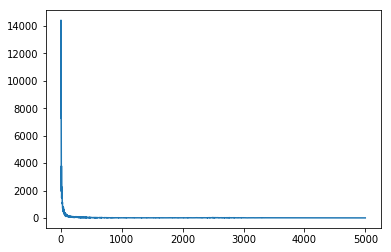

In [15]:
plt.plot(loss_array)
plt.show()